In [469]:
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tv
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from PIL import Image
import logging
import matplotlib.pyplot as plt
import copy
import pandas as pd
%matplotlib inline

In [470]:
mylogs = logging.getLogger()
mylogs.setLevel(logging.INFO)
# Logging to file
file = logging.FileHandler("training.log", mode='w')
file.setLevel(logging.INFO)
fileformat = logging.Formatter("%(asctime)s:%(levelname)s:%(message)s",datefmt="%H:%M:%S")
file.setFormatter(fileformat)
mylogs.addHandler(file)
# Logging to console
stream = logging.StreamHandler()
stream.setLevel(logging.INFO)
mylogs.addHandler(stream)

### Paths and Parameters

In [471]:
train_img_dir= "data/train/images/"
train_mask_dir =  "data/train/masks/"
test_img_dir = "data/val/images/"
test_mask_dir = "data/val/masks/"
model_name = 'Unet'
project_name = "Ocean Front Segmentation"
resize_size = (256, 256)

### Creating List of Images and Masks

In [472]:
def create_img_list(img_dir):
    img_list = []
    for (dirpath, dirnames, filenames) in os.walk(img_dir):
        img_list += [os.path.join(dirpath, file) for file in filenames]
    return img_list

In [473]:
train_img_list = create_img_list(train_img_dir)
test_img_list = create_img_list(test_img_dir)

if train_mask_dir:
    train_mask_img_list = create_img_list(train_mask_dir)
if test_mask_dir:
    test_mask_img_list = create_img_list(test_mask_dir)

In [474]:
def make_img_mask_pairs(img_list, mask_list):
    img_path_names =  {os.path.basename(n):n for n in img_list}
    mask_path_names =  {os.path.basename(n):n for n in mask_list}
    img_mask_pairs = {}
    for name, path in img_path_names.items():
        if name in mask_path_names.keys():
            img_mask_pairs[path] = mask_path_names[name]
    return(img_mask_pairs)

train_img_mask_pairs = make_img_mask_pairs(train_img_list,train_mask_img_list)
test_img_mask_pairs = make_img_mask_pairs(test_img_list,test_mask_img_list)

In [475]:
def train_val_split(img_dic, split_ratio):
    val_dic = {}
    train_dic = {}
    for i in range(int(len(img_dic)*split_ratio)):
        random_entry = random.choice(list(img_dic.keys()))
        val_dic[random_entry] = img_dic[random_entry]    
    for key in img_dic.keys():
        if key not in val_dic.keys():
            train_dic[key] = img_dic[key]
    return(train_dic, val_dic)

train_img_mask_pairs, val_img_mask_pairs = train_val_split(train_img_mask_pairs, 0.2)

### Image Loading Functions

In [476]:
def get_img_transform():
    return tv.Compose([
        tv.ToTensor(),
        tv.Normalize((0), (1)),
        
    ])
def get_mask_transform():
    return tv.Compose([
        tv.ToTensor(),
    ])
transforms = (get_img_transform(),get_mask_transform())

In [477]:
class loadDataset(Dataset):
    def __init__(self, img_mask_pairs_dic, transforms):
        super().__init__()
        self.imgs = list(img_mask_pairs_dic.keys())
        self.masks = list(img_mask_pairs_dic.values())
        self.img_transform = transforms[0]
        self.mask_transform = transforms[1]

    def __getitem__(self, idx):
        image_path = self.imgs[idx]
        mask_path = self.masks[idx]
      # Reading, converting and normalizing image
        # Reading, converting and normalizing image
        img = Image.open(image_path)
        img = img.resize((resize_size[0], resize_size[1]))
        
        # Doing the same for mask
        mask = Image.open(mask_path)
        mask = mask.resize((resize_size[0], resize_size[1]))

        # # make mask binary
        # mask = np.array(mask)
        # mask[mask > 0] = 1
        # mask = Image.fromarray(mask)

        # Apply Transforms on image
        img = self.img_transform(img)

        # creating mask tensor as a label
        mask = self.mask_transform(mask)
        return img, mask

    def __len__(self):
        return len(self.imgs)


In [478]:
train_dataset = loadDataset(train_img_mask_pairs, transforms)
val_dataset = loadDataset(val_img_mask_pairs, transforms)
test_dataset = loadDataset(test_img_mask_pairs, transforms)

In [479]:
train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 0,
    batch_size = 4,
    shuffle = True
)
val_data_loader = DataLoader(
    dataset = val_dataset,
    num_workers = 0,
    batch_size = 1,
    shuffle = True
)
test_data_loader = DataLoader(
    dataset = test_dataset,
    num_workers = 0,
    batch_size = 1,
    shuffle = True
)

# print the dimensions shape and channels of the first image in the dataset
print(train_dataset[0][0].shape)

torch.Size([4, 256, 256])


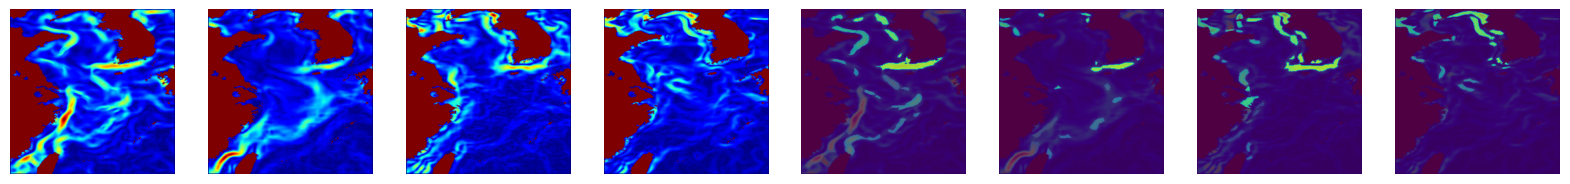

In [480]:
def dataset_preview(train_data_loader):
    for image, mask in train_data_loader:
        # create a plot of four input images and four masked images in a row
        fig, ax = plt.subplots(1, 8, figsize=(20, 10))
        for i in range(4):
            # define subplot for raw image
            ax[i].set_axis_off()
            ax[i].imshow(image[i].permute(1,2,0))
            
            # define subplot for masked image
            ax[i+4].set_axis_off()
            ax[i+4].imshow(image[i].permute(1,2,0))
            ax[i+4].imshow(mask[i].permute(1,2,0), alpha=0.8)
        # show the figure        
        plt.show()
        break

dataset_preview(train_data_loader)

### Funtions for Training 

In [481]:
# https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py
n_channels = 4
n_classes = 4
from UNet import UNet
model = UNet(n_channels, n_classes)

In [482]:
#from https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch
class DiceBCELoss(nn.Module):
    # Return Dice and Dice loss
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice_coefficient =  (2. * intersection + smooth) / (torch.sum(targets) + torch.sum(inputs) + smooth)
        
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE, dice_coefficient

In [483]:
class Optimizer:
    def __init__(self, model):
        self.optimizer_dict = {}
        self.optimizer_dict['optimizer'] = torch.optim.Adam(model.parameters(), lr = 0.0001)
        self.optimizer_dict['lr_scheduler'] = torch.optim.lr_scheduler.StepLR(self.optimizer_dict['optimizer'], step_size = 5, gamma = 0.5)
        self.optimizer_dict['criterion'] = DiceBCELoss(nn.Module)

    def return_state_dict(self):
        return self.optimizer_dict['optimizer'].state_dict()


In [484]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizerA = Optimizer(model)

In [485]:
mylogs.info("Model: " + model_name )
# Loading model to device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
mylogs.info(f"Device is: {str(device)}")
model.to(device)
optimizerA = Optimizer(model)

Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Model: Unet
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda
Device is: cuda


In [486]:
def train_one_epoch(data_loader, optimizer_obj, phase):
    ## global to local
    optimizer = optimizer_obj.optimizer_dict['optimizer']
    criterion = optimizer_obj.optimizer_dict['criterion']
    lr_scheduler = optimizer_obj.optimizer_dict['criterion'] 
    ### Local Parameters
    epoch_loss = []
    epoch_dice = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in data_loader:
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        #Reseting Gradients
        optimizer.zero_grad()
        #Forward
        preds = model(images)
        #Calculating Loss
        _loss, dice_coefficient = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(float(loss))
        epoch_dice.append(float(dice_coefficient))
        #Backward if train phase
        if phase == "train":
            _loss.backward()
            optimizer.step()
    ###Overall Epoch Results
    end_time = time.time()
    total_time = int(end_time - start_time)/60
    ###Dice coefficient and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_dice = np.mean(epoch_dice)
    ###Storing results to logs
    return epoch_loss, epoch_dice, total_time

In [487]:
def report_in_progress(phase, epoch, loss, dice, _time):
       #Print epoch details
        mylogs.info(f'{"Training" if phase == False else "Validation"} Epoch {epoch}: | Loss: {loss:.5f} | Dice: {dice:.3f} | Time: {(round(_time, 4))}')

In [488]:
def train_model(model, optimizer_obj, max_n_epochs, early_stop_epoch_thresh = 15):
    start_time = time.time()
    # initializing  training stats
    train_logs =  {"loss" : [], "dice coefficient" : [], "time" : []}
    val_logs = {"loss" : [], "dice coefficient" : [], "time" : []} 
    mylogs.info("Training started")
    best_model = model
    best_epoch = 1
    best_val_dice = 0
    bad_dice_epoch = 0
    current_epoch = 0
    best_train_logs = {}
    best_val_logs = {}
    best_model_optimizer_state_dict = optimizer_obj.return_state_dict()
    for epoch in range(1, max_n_epochs + 1):
        if bad_dice_epoch < early_stop_epoch_thresh:
            current_epoch = epoch 
            ###Training
            train_loss, train_dice, train_time = train_one_epoch(train_data_loader, optimizer_obj, "train")
            #Print train Epoch Details      
            report_in_progress(0, epoch, train_loss, train_dice, train_time)
            #Adding stats for the epoch
            train_logs["loss"].append(train_loss)
            train_logs["dice coefficient"].append(train_dice)
            train_logs["time"].append(train_time)
            ###Validation
            val_loss, val_dice, val_time = train_one_epoch(val_data_loader, optimizer_obj, "validation")
            #Print Val Epoch  Details
            report_in_progress(1, epoch, val_loss, val_dice, val_time)
            #adding stats on the epoch
            val_logs["loss"].append(val_loss)
            val_logs["dice coefficient"].append(val_dice)
            val_logs["time"].append(val_time)
            # Early stop processing
            if val_dice > best_val_dice:
                best_val_dice = val_dice
                best_model = copy.deepcopy(model)
                bad_dice_epoch = 0
                best_train_logs = train_logs
                best_val_logs = val_logs
                best_epoch = epoch 
            else:
                bad_dice_epoch +=1
        else:
            mylogs.info(f"Early stop, best dice coefficient: {best_val_dice}%")
            break
    end_time = time.time()
    total_time = end_time - start_time
    mylogs.info(f"Total time : {int(total_time/60)}")
    # packing training data into a dictionary
    training_stats = {}
    training_stats['train logs'] = train_logs
    training_stats['validation logs'] = val_logs
    training_stats['best train logs'] = best_train_logs
    training_stats['best validation logs'] = best_val_logs
    training_stats['best validation dice'] = best_val_dice
    training_stats['best epoch'] = best_epoch
    training_stats['current epoch'] = current_epoch 
    
    return best_model, best_model_optimizer_state_dict, training_stats

In [489]:
# Training 
n_of_epochs = 20
model, model_optimizer_state_dict,  training_stats = train_model(model, optimizerA, n_of_epochs)

Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started
Training started


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 3.94 GiB total capacity; 2.56 GiB already allocated; 38.88 MiB free; 2.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def train_vis(training_stats):

    ### Plotting Results
    train_logs = training_stats['train logs']
    val_logs = training_stats['validation logs']
    epochs = training_stats['current epoch'] + 1
    best_epoch = training_stats['best epoch'] 

#Loss
    plt.figure(figsize=(15, 6))
    
    plt.title("Loss",color='black')
    plt.plot(np.arange(1, epochs), train_logs["loss"], color = 'blue', label='Training')
    plt.plot(np.arange(1, epochs), val_logs["loss"], color = 'orange', label='Validation')
    plt.axvline(x=best_epoch,color='green')
    plt.xticks(ticks=range(1, epochs), color='black')
    plt.yticks(color='black')
    plt.xlabel("Epochs", color = 'black')
    plt.ylabel("Loss", color = 'black')
    plt.show()

# dice coefficient
    plt.figure(figsize=(15, 6))
    plt.title("Dice", color='black')
    plt.plot(np.arange(1, epochs), train_logs["dice coefficient"], color = 'blue', label='Training')
    plt.plot(np.arange(1, epochs), val_logs["dice coefficient"], color = 'orange', label='Validation')
    plt.axvline(x=best_epoch, color='green')
    plt.xticks(ticks=range(1, epochs), color='black')
    plt.yticks(color='black')
    plt.xlabel("Epochs", color = 'black')
    plt.ylabel("Accuracy", color='black')
    plt.show()